In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from collections import *
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
import cv2
import warnings

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [5]:
df = pd.read_csv('data/train.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


# Check Images

In [6]:
from glob import glob
image_paths = sorted(glob('data/train-jpg/*.jpg'))[0:10]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

['train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_1000',
 'train_10000',
 'train_10001',
 'train_10002',
 'train_10003',
 'train_10004']

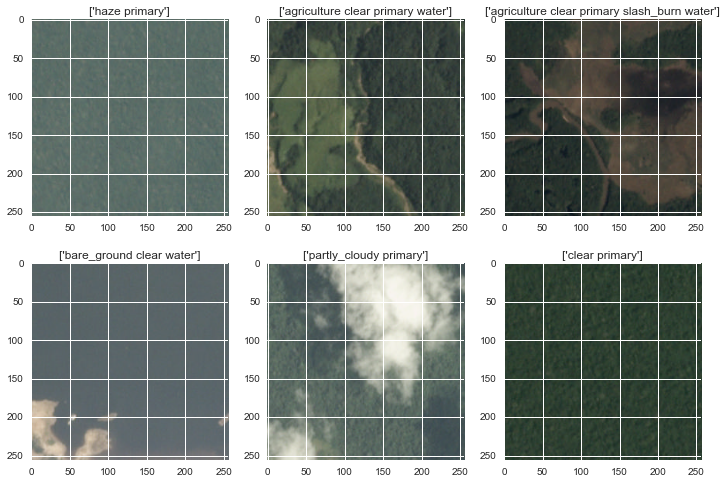

In [7]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(image_paths[i]))
    plt.title(str(df[df.image_name == image_names[i]].tags.values))

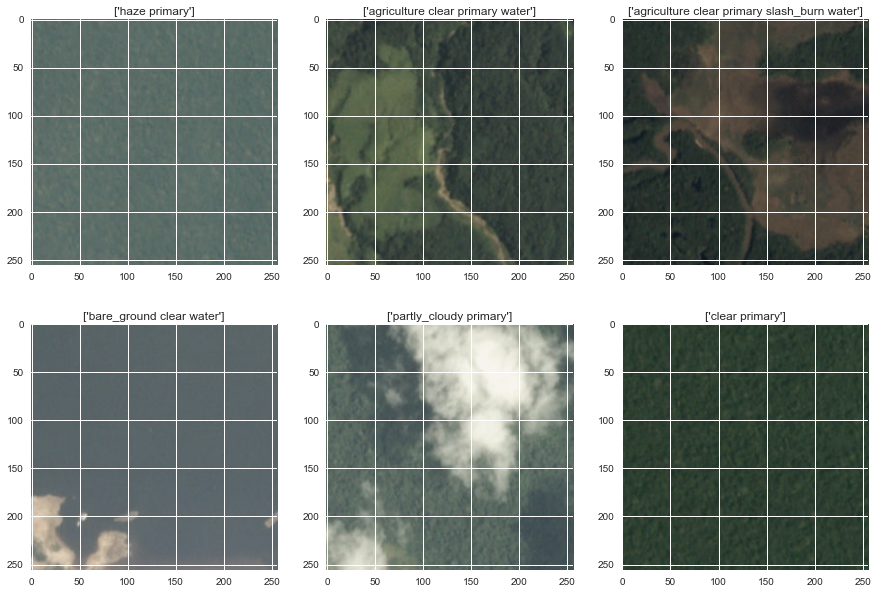

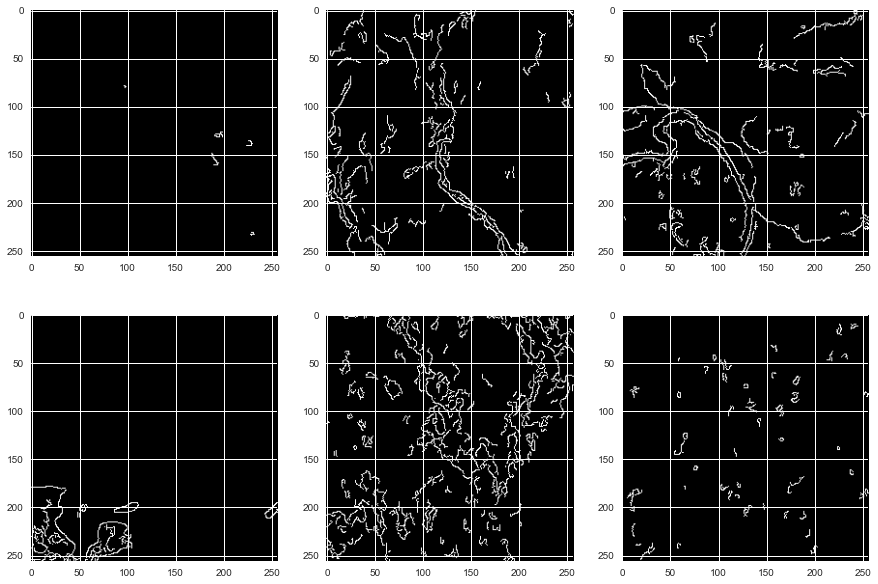

In [10]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(image_paths[i]))
    plt.title(str(df[df.image_name == image_names[i]].tags.values))
plt.show()
for j in range(6):
    plt.subplot(2,3,j+1),plt.imshow(cv2.Canny(plt.imread(image_paths[j]),50,100),cmap='gray')

plt.show()

In [9]:
df.head(10)['image_name'].values

array(['train_0', 'train_1', 'train_2', 'train_3', 'train_4', 'train_5',
       'train_6', 'train_7', 'train_8', 'train_9'], dtype=object)

In [7]:
# Process data into training set and labels

%time
n_samples = 500 #small sampling dataset
rescaled_dim = 20

df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]

#sample
print "classes:"
print lb.classes_
print "y shape:", y.shape
print "y labels look like this:"
print y[:5]

CPU times: user 4 µs, sys: 7 µs, total: 11 µs
Wall time: 22.9 µs
classes:
['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']
y shape: (500, 17)
y labels look like this:
[[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0]]


In [8]:
imgs = []
# for each image, rescale to same dimension and flattern
for name in df.head(n_samples)['image_name'].values:
    raw_img = plt.imread('data/train-jpg/{}.jpg'.format(name))
    #print raw_img
    imgs.append(cv2.resize(raw_img, (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1))

# remove dimenions    
X = np.squeeze(np.array(imgs))

# scale X so that each feature be between 0 and 1
X = MinMaxScaler().fit_transform(np.float32(X))

print "X shape:",(X.shape)
print np.min(X, axis=0), np.max(X, axis=0)

X shape: (500, 1600)
[ 0.  0.  0. ...,  0.  0.  0.] [ 0.99999994  1.          1.         ...,  1.          1.          0.        ]


In [9]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((335, 1600), (165, 1600), (335, 17), (165, 17))


In [20]:
clf = KNeighborsClassifier(n_neighbors=9)
clf.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [21]:
# evaluate output

score = fbeta_score(y_test, clf.predict(X_test), beta=2, average=None)
avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')
print('Average F2 test score {}'.format(avg_sample_score))
print('F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]

Average F2 test score 0.661589655992
F2 test scores per tag:


[('primary', 0.96605744125326376),
 ('clear', 0.87060702875399365),
 ('cloudy', 0.48780487804878053),
 ('haze', 0.3125),
 ('agriculture', 0.13020833333333334),
 ('water', 0.041322314049586778),
 ('road', 0.033333333333333333),
 ('partly_cloudy', 0.0),
 ('habitation', 0.0),
 ('slash_burn', 0.0),
 ('conventional_mine', 0.0),
 ('selective_logging', 0.0),
 ('blow_down', 0.0),
 ('blooming', 0.0),
 ('bare_ground', 0.0),
 ('artisinal_mine', 0.0),
 ('cultivation', 0.0)]

In [24]:
# evaluate accuracy
score = clf.score(X_test, y_test)
print('Accuracy {}').format(score)

Accuracy 0.387878787879
